# SURF, SIFT Descriptors


In [1]:
import cv2 as cv
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data_folder1 = os.path.join(os.curdir,'dataset1(kvadr)')
data_set1 = [os.path.join(data_folder1,file) for file in os.listdir(data_folder1) if os.path.isfile(os.path.join(data_folder1,file))]
data_folder2 = os.path.join(os.curdir,'dataset2(pony)')
data_set2 = [os.path.join(data_folder2,file) for file in os.listdir(data_folder2) if os.path.isfile(os.path.join(data_folder2,file))]


In [3]:
kvadrs = [cv.imread(image,0) for image in data_set1]

In [4]:
ponies = [cv.imread(image,0) for image in data_set2]

In [12]:
data_set1

['./dataset1(kvadr)/IMG_3091.JPG',
 './dataset1(kvadr)/IMG_3380(1).jpg',
 './dataset1(kvadr)/IMG_3050.jpg',
 './dataset1(kvadr)/IMG_3350.JPG',
 './dataset1(kvadr)/IMG_3097.jpg',
 './dataset1(kvadr)/IMG_3053.jpg',
 './dataset1(kvadr)/IMG_3391(1).JPG',
 './dataset1(kvadr)/IMG_3062.jpg',
 './dataset1(kvadr)/IMG_3533.JPG',
 './dataset1(kvadr)/IMG_3059.jpg',
 './dataset1(kvadr)/IMG_3391.JPG',
 './dataset1(kvadr)/IMG_3056.jpg',
 './dataset1(kvadr)/IMG_3109.JPG',
 './dataset1(kvadr)/IMG_3187.jpg',
 './dataset1(kvadr)/IMG_3060.jpg',
 './dataset1(kvadr)/IMG_3124.jpg',
 './dataset1(kvadr)/IMG_3130.JPG',
 './dataset1(kvadr)/IMG_3065.jpg',
 './dataset1(kvadr)/IMG_3358.JPG',
 './dataset1(kvadr)/IMG_3499.JPG',
 './dataset1(kvadr)/IMG_3178.JPG',
 './dataset1(kvadr)/IMG_3353.JPG',
 './dataset1(kvadr)/IMG_3365.jpg',
 './dataset1(kvadr)/IMG_3075.JPG',
 './dataset1(kvadr)/IMG_3366.JPG',
 './dataset1(kvadr)/IMG_3063.jpg',
 './dataset1(kvadr)/IMG_3415.JPG',
 './dataset1(kvadr)/IMG_3070.jpg',
 './dataset1(k

In [10]:
surf = cv.xfeatures2d.SURF_create(700)
sift = cv.xfeatures2d.SIFT_create()

In [5]:
kp1, des1 = surf.detectAndCompute(kvadrs[7],None)
kp2, des2 = surf.detectAndCompute(kvadrs[2],None)

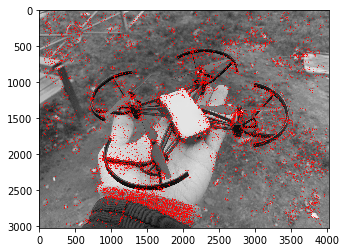

(<matplotlib.image.AxesImage at 0x7fb4022bf110>, None)

In [26]:
img1 = cv.drawKeypoints(kvadrs[7],kp1,None,(255,0,0),4)

plt.imshow(img1),plt.show()


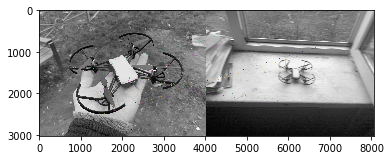

(<matplotlib.image.AxesImage at 0x7fb402277c10>, None)

In [16]:
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv.drawMatches(kvadrs[7],kp1,kvadrs[2],kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()


In [56]:
MIN_MATCH_COUNT = 10

In [40]:
key_pts1, key_pts2, good, matchesMask,msed = compare(descriptor=surf.detectAndCompute,img1=kvadrs[9],img2=kvadrs[13],
                                                     min_match_count=10)

In [45]:
import itertools
import time

In [7]:
alg_dict=dict(sift=cv.xfeatures2d.SIFT_create().detectAndCompute,
              surf=cv.xfeatures2d.SURF_create(700).detectAndCompute)
inliers_matches = dict()
indexes = list(itertools.product(alg_dict.keys(),["inliers/matches","distance MSE","time (s)"]))
for im_j_idx in range(len(ponies)):
    inliers_matches["img"+str(im_j_idx)]=list()

In [16]:
msed, len(pts)

(0.49270844, 4)

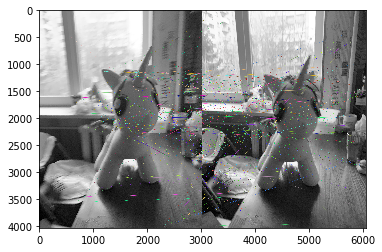

(<matplotlib.image.AxesImage at 0x7f8a399b0b38>, None)

In [24]:
img3 = cv.drawMatchesKnn(ponies[0],kpts1,ponies[1],kpts2,matches[:50],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

In [17]:
def detect_match(algorithm,query_img,train_img,min_match_count,verbose=False):
    query_image = query_img
    train_image = train_img
    key_pts1,des1 = algorithm(query_image,None)
    key_pts2,des2 = algorithm(train_image,None)
    msed=np.inf
    if not (isinstance(des1,np.float32)&isinstance(des2,np.float32)):
        des1 = np.float32(des1)
        des2 = np.float32(des2)
    
    flann_idx = 1
    index_params = dict(algorithm = flann_idx, trees = 5)
    search_params = dict(checks = 50)

    flann = cv.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = [m for m,n in matches if m.distance < 0.55*n.distance]
    
    if len(good)>min_match_count:
        src_pts = np.float32([ key_pts1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ key_pts2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        if M is None:
            return [0],[0],[0],[0],np.inf
        #print(M,mask)
        matchesMask = mask.ravel().tolist()
        h,w = query_image.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts,M)
        msed = np.mean([np.sqrt(np.sum(diff)) for diff in (np.power(pts-dst,2))]/(np.sqrt(h**2+w**2)))
        #cv2.polylines(train_image,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    else:
        if verbose==True:
            print( "Not enough matches are found - {}/{}".format(len(good), min_match_count) )
        matchesMask = [0]
    
    return key_pts1, key_pts2, good, matchesMask, msed

def plot_match(query_img, train_img, key_pts1, key_pts2, good, matchesMask):
    draw_params = dict(matchColor = (255.0,255.0,255.0), # draw matches in white color
                   singlePointColor = (255.0,0,0),
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img3 = cv.drawMatches(query_img, key_pts1, train_img, key_pts2, good, None, **draw_params)
    plt.imshow(img3, 'gray'),

In [18]:
import itertools
import time
inliers_matches = dict()
indexes = list(itertools.product(alg_dict.keys(),["inliers/matches","distance MSE","time (s)"]))
for im_j_idx in range(len(ponies[:10])):
    inliers_matches["img"+str(im_j_idx)]=list()

In [19]:
for alg_name, alg in alg_dict.items():
    for im_i_idx, image_i in enumerate(ponies[:10]):
        time_start=time.monotonic()
        _, __, match, inlier ,msd = detect_match(algorithm=alg,query_img=image_i,train_img=ponies[13],
                                                     min_match_count=5)
        time_end=time.monotonic()
        if match==0:
            match=np.inf
        inliers_matches["img"+str(im_i_idx)].append(np.sum(inlier)/(len(match)))
        inliers_matches["img"+str(im_i_idx)].append(msd)
        inliers_matches["img"+str(im_i_idx)].append(time_end-time_start)

/home/eduard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [20]:
import pandas as pd
index = pd.MultiIndex.from_tuples(indexes,names=['algorithm','property'])
comparison_df=pd.DataFrame(inliers_matches,index=index)

In [21]:
comparison_df

img0      img1      img2      img3      img4  \
algorithm property                                                            
sift      inliers/matches  0.000000  0.000000  0.000000       NaN  0.674797   
          distance MSE          inf       inf       inf       inf  0.003953   
          time (s)         6.271783  6.354146  6.403083  5.927503  6.227083   
surf      inliers/matches       NaN       NaN       NaN       NaN  0.774194   
          distance MSE          inf       inf       inf       inf  0.005387   
          time (s)         2.808005  3.131812  2.867781  2.367231  2.444752   

                               img5      img6      img7      img8      img9  
algorithm property                                                           
sift      inliers/matches  0.000000  0.000000       NaN       NaN       NaN  
          distance MSE          inf       inf       inf       inf       inf  
          time (s)         6.060678  6.473418  5.815563  6.578426  6.680844  
surf      inliers/matches  0.000000  0.000000       NaN  0.000000       NaN  
          distance MSE          inf       inf       inf       inf       inf  
          time (s)         3.677915  3.056232  2.357456  3.333903  2.862547